### Burger's equation
For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:
$$u_t + uu_x = \nu u_{xx} $$
Consider initial value problem:
$$u(x,0) = u_0(x) $$
for periodic boundary conditions on an interval of length $L$:
$$ u(x+L, t) = u(x,t)$$
Introduce grid values $u_k(t) = u(\frac{kL}{N},t)$ for $k = 0, \dots , N-1$.

Let $\Delta x = \frac{L}{N}$, $\Delta t = \frac{T}{M}$, $u_k^j = u( k \Delta x, n \Delta t)$

Discretize $ u_{xx}$,$u u_x $, $u_t$ by
$$ u_{xx} = (\frac{N}{L})^2 (u_{k+1} + u_{k-1} - 2 u_k) = \frac{u_{k+1} + u_{k-1} - 2 u_k}{(\Delta x)^2}$$
$$ u u_x = (\frac{N}{2 L}) u_k (u_{k+1} - u_{k-1}) = \frac{u_k (u_{k+1} - u_{k-1})}{2 \Delta x}$$
$$ u_t = \frac{u_k^{n+1} - u_k^n}{\Delta t}$$
The equation is approximated by 
$$ \frac{u_k^{n+1} - u_k^n}{\Delta t} + \frac{u_k^n (u_{k+1}^n - u_{k-1}^n)}{2 \Delta x} = \nu \frac{u_{k+1}^n + u_{k-1}^n - 2 u_k^n}{(\Delta x)^2} $$
$$ u_k^{n+1} = u_k^n  -\frac{\Delta t}{2 \Delta x} (u_k^n (u_{k+1}^n - u_{k-1}^n)) + \frac{\nu \Delta t}{(\Delta x)^2}(u_{k+1}^n + u_{k-1}^n - 2 u_k^n) $$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools
from IPython.display import display, HTML, display_html, Latex
import pandas as pd

In [3]:
def CK_Burger(N, nu, T, M, L, initial):
    dx = L/N
    dt = T/M 
    x = np.linspace(-L/2, L/2, N+1)  # Spatial grid points, N+1 in total
    u_initial = initial(x)
    u = np.zeros((N+1, M+1), dtype=np.double) # Spatial grid points x_0, ...., x_N; timesteps t_0, ...., t_M
    u[:,0] = u_initial
    p = dt / (4* dx)
    r = (nu*dt) / (2*dx**2)
    
    #Ainv = np.linalg.inv(A) 
    for n in range(1, M+1):
        u[0,n] = u[-1,n-1]
        
        #b = np.zeros(N)
        #b[0] = r*(u[0, n-1] + u[0, n])
        #b[N-1] = -r*(u[N,n-1] + u[N,n])
        #v = np.dot(B, u[1:N+1,n-1])
        #u[1:N+1,n] = np.dot(Ainv,v+b)
        
        A = np.zeros((N+1, N+1))
        B = np.zeros_like(A)
        for i in range (1,N):  
            A[i,i] = 2*r +1 + p*(u[i+1,n-1] - u[i-1,n-1] )
            A[i,i-1]= -r - p*u[i,n-1]
            A[i,i+1]= -r + p*u[i,n-1]
            
            B[i,i] = 1 - 2*r
            B[i,i-1]= r
            B[i,i+1]= r
        
        A[0, 0], A[0, -1], A[0, 1] = 2*r + 1 + p*(u[1, n-1] - u[-1, n-1]), -r - p*u[0, n-1], -r + p*u[0, n-1]
        A[-1, -1], A[-1, -2], A[-1, 0] = 2*r + 1 + p*(u[0, n-1] - u[-2, n-1]), -r - p*u[-1, n-1], -r + p*u[0, n-1]
        B[0, 0], B[0, -1], B[0, 1] = 1-2*r, r, r
        B[-1, -1], B[-1, -2], B[-1,0] = 1-2*r, r, r
        u_new = np.linalg.solve(A, B @ u[:,n-1])
        u[:,n] = u_new.copy()

    return u


def GaussianInitial(x):
    x = np.array(x)
    return np.exp(-x**2)

In [4]:


N = 256
M = 200
T = 10
L = 10
D = 3
P = 3
dt = T / M
dx = L / N
x = np.linspace(-L/2, L/2, N+1)
t = np.linspace(0, T, M+1)
t_grid, x_grid = np.meshgrid(t,x)


### Take $\nu = 0.2$ and compare the performance of PDE-FIND using Ridge regression and LASSO regression
Samuel Rudy's original paper did not cover the performance of LASSO regression and Elastic Net regression. Here we write a function `TrainLasso` similar to `TrainSTRidge` in the original `PDE-FIND` to implement LASSO regression and ran on the same datasets and try to rediscover the equation
$$ u_t = -u u_x + 0.2 u_{xx}$$

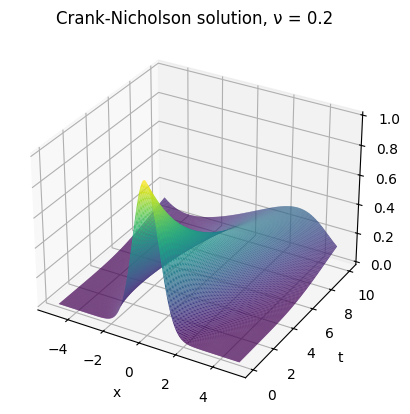

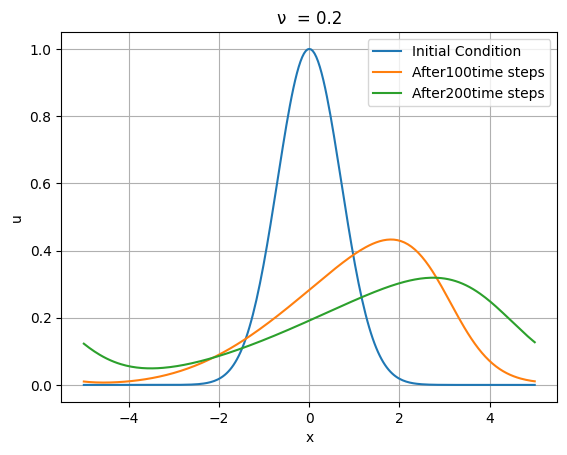

In [5]:
nu = 0.2
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_02')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_02')
plt.show()

**STRidge and LASSO**  
LASSO regression:
$$ L = \| Ax - b\|_x + \lambda \| x\|_1$$
Uses a 1-norm. 1-norm promotes sparsity. It will make as many entries zero as possible. You will get a x vector that's very sparse and highlights columns of A that are most relevant. It also prevents overfitting because we only select variables that are most important. Python sklearn.linear_model.Lasso 
$\lambda$ decides how sparse you want your vector to be. Big $\lambda$ gives ultra-sparse vector.$\lambda = 0$ gives the least-square solution.  

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [7]:
# Solve withFoBaGreedy
w = FoBaGreedy(R,Ut)
print("PDE derived using FoBaGreedy")
print_pde(w, rhs_des)

err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using FoBaGreedy to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

c:\Users\zzh\URSS\PDE_FIND.py:889: ComplexWarning: Casting complex values to real discards the imaginary part
  w_added[list(F_trial)] = np.linalg.lstsq(X[:, list(F_trial)], y, rcond=None)[0]


PDE derived using FoBaGreedy
u_t = (-1.000130 +0.000000i)uu_{x}
    + (0.199622 +0.000000i)u_{xx}
   
Error using FoBaGreedy to identify Burger's equation:

Mean parameter error: 0.012619514 %
Standard deviation of parameter error: 0.04562249 %


In [8]:
# Solve with TrainLasso
import time
st = time.time()
w = TrainSTLasso(R,Ut,10**-5,0.01)
ed = time.time()
print("PDE derived using TrainLASSO")
print_pde(w, rhs_des)

print("PDE derived using TrainLASSO after thresholding")
print(f"taken {ed-st} seconds")
err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using LASSO to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using TrainLASSO
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
PDE derived using TrainLASSO after thresholding
taken 15.412600040435791 seconds
Error using LASSO to identify Burger's equation:

Mean parameter error: 0.012181335211898514 %
Standard deviation of parameter error: 0.04308110326328677 %


In [9]:
import time
# Solve with STRidge
st = time.time()
w = TrainSTRidge(R,Ut,10**-5,1)
ed = time.time()
print("PDE derived using STRidge")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")
err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using STRidge to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%\n')


PDE derived using STRidge
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Taken 2.3299739360809326 seconds
Error using STRidge to identify Burger's equation:

Mean parameter error: 0.012181820678127536 %
Standard deviation of parameter error: 0.043082548874742006 %



Result shows that for the same value of $\lambda$ and initial tolerance, `TrainSTRidge` manages to retrieve the governing equation, whilst `Lasso`, despite having correctly identified the coefficients of $u u_x$ and $u_{xx}$, has picked up unrelated terms.  

In [10]:
lam1 = 10**-5
lam2 = 10**-5
# Solve with Elastic Net
import time
st = time.time()
w = TrainSTElasticNet(R,Ut,lam1,lam2,0.01)
ed = time.time()
print("PDE derived using Elastic Net")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")


err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using Elastic Net to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using Elastic Net
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Taken 15.504409074783325 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 0.012181335211898514 %
Standard deviation of parameter error: 0.04308110326328677 %


#### Vary $\lambda_1$ and $\lambda_2$ for Elastic Net

In [ ]:
lam1s = [10**i for i in range(-5, 2)]
lam2s = [10**i for i in range(-5, 2)]
mean_par_errs = np.zeros((len(lam1s),len(lam2s)))
std_errs = np.zeros((len(lam1s),len(lam2s)))
# Solve with Elastic Net
import time
st = time.time()
for i in range(len(lam1s)):
    lam1 = lam1s[i]
    for j in range(len(lam2s)):
        lam2 = lam2s[j]
        w = TrainSTElasticNet(R,Ut,lam1,lam2,0.01)
        ed = time.time()
        print(f"PDE derived using Elastic Net lam1 = {lam1}, lam2 = {lam2}")
        print_pde(w, rhs_des)
        print(f"Taken {ed - st} seconds")


        err = abs(np.array([(-1 -  w[5])*100, (nu - w[8])*100/nu]))
        print("Error using Elastic Net to identify Burger's equation:\n")
        print("Mean parameter error:", np.mean(err), '%')
        mean_par_errs[i,j] = np.mean(err)
        print("Standard deviation of parameter error:", np.std(err), '%')
        std_errs = np.std(err)

PDE derived using Elastic Net lam1 = 1e-05, lam2 = 1e-05
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Taken 9.123448610305786 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 0.09745068169518811 %
Standard deviation of parameter error: 0.08085972869454894 %
PDE derived using Elastic Net lam1 = 1e-05, lam2 = 0.0001
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Taken 15.912576675415039 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 0.09745068169518811 %
Standard deviation of parameter error: 0.08085972869454894 %
PDE derived using Elastic Net lam1 = 1e-05, lam2 = 0.001
u_t = (-1.000166 +0.000000i)uu_{x}
    + (0.199643 +0.000000i)u_{xx}
   
Taken 22.59899353981018 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 0.09745068169518811 %
Standard deviation of parameter error: 0.08085972869454894 %
PDE derived using Elastic Net

c:\Users\zzh\URSS\PDE_FIND.py:675: ComplexWarning: Casting complex values to real discards the imaginary part
  w[j] = np.multiply(np.sign(z[j])[0], np.max([abs(z[j])[0]-max(lam1, lam2)/L,0]))


#### nu = 2


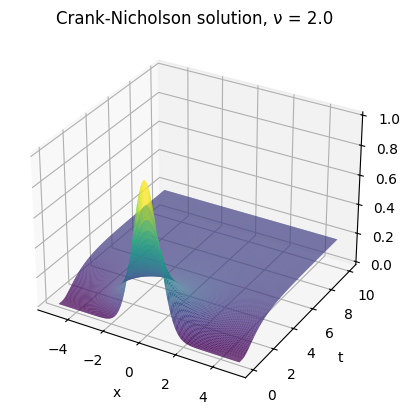

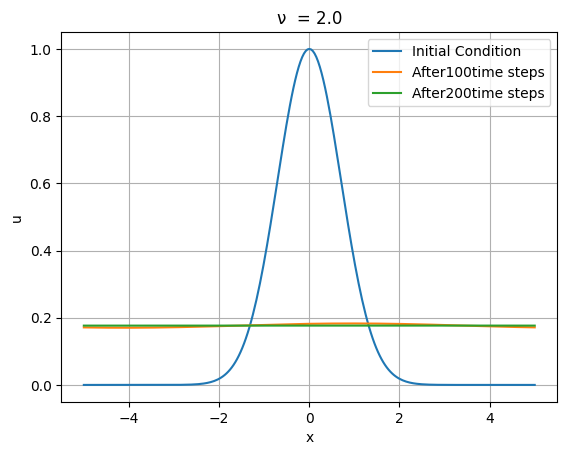

In [11]:
nu = 2.0
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_02')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_02')
plt.show()

In [12]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [13]:
# Solve with TrainLasso
import time
st = time.time()
w = TrainSTLasso(R,Ut,10**-5,0.1)
ed = time.time()
print("PDE derived using TrainLASSO")
print_pde(w, rhs_des)
print("PDE derived using TrainLASSO after thresholding")
print(f"taken {ed-st} seconds")

err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using LASSO to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using TrainLASSO
u_t = (-0.034712 +0.000000i)u
    + (0.266231 +0.000000i)u^2
    + (-0.402183 +0.000000i)u^3
    + (-1.128111 +0.000000i)uu_{x}
    + (1.411022 +0.000000i)u^2u_{x}
    + (-3.404204 +0.000000i)u^3u_{x}
    + (2.046936 +0.000000i)u_{xx}
    + (-0.750407 +0.000000i)uu_{xx}
    + (2.284233 +0.000000i)u^2u_{xx}
    + (-1.792301 +0.000000i)u^3u_{xx}
    + (-0.396617 +0.000000i)u^3u_{xxx}
   
PDE derived using TrainLASSO after thresholding
taken 18.472562313079834 seconds
Error using LASSO to identify Burger's equation:

Mean parameter error: 68.08429756676988 %
Standard deviation of parameter error: 98.62842738666157 %


In [14]:

# Solve with STRidge
st = time.time()
w = TrainSTRidge(R,Ut,10**-5,0.1)
ed = time.time()
print("PDE derived using STRidge")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")
err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using STRidge to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%\n')

PDE derived using STRidge
u_t = (0.000286 +0.000000i)
    + (-0.039955 +0.000000i)u
    + (0.296344 +0.000000i)u^2
    + (-0.457437 +0.000000i)u^3
    + (0.056596 +0.000000i)u_{x}
    + (-1.879838 +0.000000i)uu_{x}
    + (4.210464 +0.000000i)u^2u_{x}
    + (-6.025522 +0.000000i)u^3u_{x}
    + (2.046360 +0.000000i)u_{xx}
    + (-0.741660 +0.000000i)uu_{xx}
    + (2.220960 +0.000000i)u^2u_{xx}
    + (-1.751078 +0.000000i)u^3u_{xx}
    + (-0.008975 +0.000000i)u_{xxx}
    + (0.060372 +0.000000i)uu_{xxx}
    + (0.125388 +0.000000i)u^2u_{xxx}
    + (-0.664818 +0.000000i)u^3u_{xxx}
   
Taken 3.4164302349090576 seconds
Error using STRidge to identify Burger's equation:

Mean parameter error: 109.767944 %
Standard deviation of parameter error: 167.41316 %



In [15]:
lam1 = 10**-5
lam2 = 10**-5

# Solve with Elastic Net
import time
st = time.time()
w = TrainSTElasticNet(R,Ut,lam1,lam2,0.1)
ed = time.time()
print("PDE derived using Elastic Net")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")


err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using Elastic Net to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using Elastic Net
u_t = (-0.034712 +0.000000i)u
    + (0.266231 +0.000000i)u^2
    + (-0.402183 +0.000000i)u^3
    + (-1.128111 +0.000000i)uu_{x}
    + (1.411022 +0.000000i)u^2u_{x}
    + (-3.404204 +0.000000i)u^3u_{x}
    + (2.046936 +0.000000i)u_{xx}
    + (-0.750407 +0.000000i)uu_{xx}
    + (2.284233 +0.000000i)u^2u_{xx}
    + (-1.792301 +0.000000i)u^3u_{xx}
    + (-0.396617 +0.000000i)u^3u_{xxx}
   
Taken 18.13982653617859 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 68.08429756676988 %
Standard deviation of parameter error: 98.62842738666157 %


#### $\nu$ = 0.02

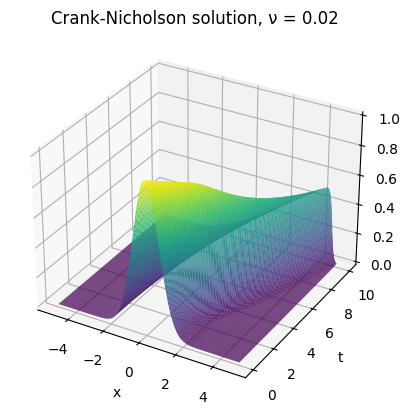

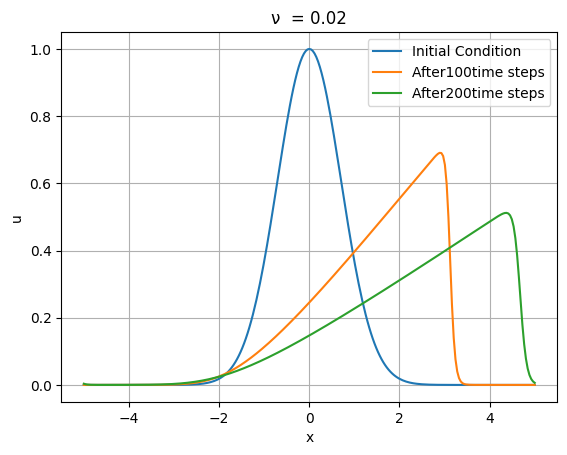

In [16]:
nu = 0.02
u = CK_Burger(N, nu, T, M, L, GaussianInitial)


ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, t_grid, u, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Crank-Nicholson solution, ν = ' + str(nu));
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('Burger3d_02')

plt.figure()
plt.plot(x,GaussianInitial(x), label='Initial Condition')
plt.plot(x, u[:, int(M/2)], label='After' + str(int(M/2))+ 'time steps')
plt.plot(x, u[:, M], label='After' + str(M) + 'time steps')
plt.legend()
plt.title('ν  = ' + str(nu))
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.savefig('Burger2d_02')
plt.show()

In [17]:
# Solve with TrainLasso
import time
st = time.time()
w = TrainSTLasso(R,Ut,10**-5,0.1)
ed = time.time()
print("PDE derived using TrainLASSO")
print_pde(w, rhs_des)
print("PDE derived using TrainLASSO after thresholding")
print(f"taken {ed-st} seconds")

err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using LASSO to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using TrainLASSO
u_t = (-0.034712 +0.000000i)u
    + (0.266231 +0.000000i)u^2
    + (-0.402183 +0.000000i)u^3
    + (-1.128111 +0.000000i)uu_{x}
    + (1.411022 +0.000000i)u^2u_{x}
    + (-3.404204 +0.000000i)u^3u_{x}
    + (2.046936 +0.000000i)u_{xx}
    + (-0.750407 +0.000000i)uu_{xx}
    + (2.284233 +0.000000i)u^2u_{xx}
    + (-1.792301 +0.000000i)u^3u_{xx}
    + (-0.396617 +0.000000i)u^3u_{xxx}
   
PDE derived using TrainLASSO after thresholding
taken 18.81946039199829 seconds
Error using LASSO to identify Burger's equation:

Mean parameter error: 701.3550829628336 %
Standard deviation of parameter error: 2437.610838443279 %


In [18]:
# Solve with STRidge
st = time.time()
w = TrainSTRidge(R,Ut,10**-5,0.1)
ed = time.time()
print("PDE derived using STRidge")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")
err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using STRidge to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%\n')

PDE derived using STRidge
u_t = (0.000286 +0.000000i)
    + (-0.039955 +0.000000i)u
    + (0.296344 +0.000000i)u^2
    + (-0.457437 +0.000000i)u^3
    + (0.056596 +0.000000i)u_{x}
    + (-1.879838 +0.000000i)uu_{x}
    + (4.210464 +0.000000i)u^2u_{x}
    + (-6.025522 +0.000000i)u^3u_{x}
    + (2.046360 +0.000000i)u_{xx}
    + (-0.741660 +0.000000i)uu_{xx}
    + (2.220960 +0.000000i)u^2u_{xx}
    + (-1.751078 +0.000000i)u^3u_{xx}
    + (-0.008975 +0.000000i)u_{xxx}
    + (0.060372 +0.000000i)uu_{xxx}
    + (0.125388 +0.000000i)u^2u_{xxx}
    + (-0.664818 +0.000000i)u^3u_{xxx}
   
Taken 3.0054643154144287 seconds
Error using STRidge to identify Burger's equation:

Mean parameter error: 742.86053 %
Standard deviation of parameter error: 2429.829 %



In [19]:
lam1 = 10**-5
lam2 = 10**-5

# Solve with Elastic Net
import time
st = time.time()
w = TrainSTElasticNet(R,Ut,lam1,lam2,0.1)
ed = time.time()
print("PDE derived using Elastic Net")
print_pde(w, rhs_des)
print(f"Taken {ed - st} seconds")


err = w.copy()
err[5] = -1 -  w[5]
err[8] = (nu - w[8]) /nu
err = abs(np.array(err))
err *= 100
print("Error using Elastic Net to identify Burger's equation:\n")
print("Mean parameter error:", np.mean(err), '%')
print("Standard deviation of parameter error:", np.std(err), '%')

PDE derived using Elastic Net
u_t = (-0.034712 +0.000000i)u
    + (0.266231 +0.000000i)u^2
    + (-0.402183 +0.000000i)u^3
    + (-1.128111 +0.000000i)uu_{x}
    + (1.411022 +0.000000i)u^2u_{x}
    + (-3.404204 +0.000000i)u^3u_{x}
    + (2.046936 +0.000000i)u_{xx}
    + (-0.750407 +0.000000i)uu_{xx}
    + (2.284233 +0.000000i)u^2u_{xx}
    + (-1.792301 +0.000000i)u^3u_{xx}
    + (-0.396617 +0.000000i)u^3u_{xxx}
   
Taken 18.670020818710327 seconds
Error using Elastic Net to identify Burger's equation:

Mean parameter error: 701.3550829628336 %
Standard deviation of parameter error: 2437.610838443279 %
